# Timing and duration of the LJE
This notebook can be used to: 
- Compute the onset, peak, and termination of the LJE for each posterior draw
- Plot probability distributions and compute probability envelopes/most likely values for the excursion timing, magnitude, and duration

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import stratmc
import warnings 

from pathlib import Path
from scipy.ndimage import gaussian_filter as gaussian
from tqdm.notebook import tqdm

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Avenir']
rcParams.update({
    "text.usetex": False
})

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

## Import data

In [2]:
section_metadata = pd.read_csv('data/paleoproterozoic_section_metadata.csv')

sample_df, ages_df =  stratmc.data.load_data('data/paleoproterozoic_data', 
                                             'data/paleoproterozoic_ages', 
                                             combine_no_superposition = False)

sample_df_downsampled = stratmc.data.load_object('data/downsampling/downsampled_sample_df')


## Load Paleoproterozoic d13C inference

In [9]:
# load the 'all-data' inference results
full_trace = stratmc.data.load_trace("traces/" + "paleoproterozoic_d13C_trace")

## Calculate excursion peak, onset, and termination
Note - chain 7 signals are very jagged, and sometimes end up with spuriuos inflection points identified as the onset

chain 15 was also having problems, because it's increasing during the entire pre-peak interval/decreasing for the entire post-peak interval. altered onset selection criteria to grab first point with d13C <=2 (instead of the lowest zero-crossing). Still not very reliable (a lot of variation due to jaggedness more so than actual differences in the signal), but more reasonable

In [14]:
duration = [] 
magnitude = []
excursion_magnitude = [] 
onset_list = []
onset_d13C_list = [] 
termination_list = []
termination_d13C_list = []
peak_list = [] 
peak_d13C_list = [] 
idx_list = []

# whether to create and save a figure showing the selected onset and peak for each posterior draw. 
plot = True
leg = True

# create a folder to save figures
if plot: 
    folder = f'figures/excursion_timing/'
    dir_path = Path(folder)

    if not dir_path.is_dir():
        dir_path.mkdir()

# total number of posterior draws = chains x draws per chain
n_draws = len(full_trace.posterior.chain.values) * len(full_trace.posterior.draw.values) 

# extract posterior d13C signal inference from trace
# shape = ages x draws 
d13c_pred = az.extract(full_trace.posterior_predictive)['f_pred_d13c'].values

# age vector corresponding to d13C predictions
ages_new = full_trace.X_new.X_new.values.ravel()

# flip the age vector (oldest --> youngest) 
ages_new = np.flip(ages_new)

# iterate over posterior raws
for idx in tqdm(np.arange(n_draws)): 
    
    # current d13C signal, flipped to match age vector (oldest --> youngest)
    test_d13C = np.flip(d13c_pred[:, idx])

    # compute gradient of d13C signal
    # smooth to get rid of minor noise/jaggedness to curve
    grad = np.gradient(gaussian(test_d13C, 3), ages_new.ravel())

    # find zero-crossings of the gradient (i.e., inflection points)
    zero_crossings = np.where(np.diff(np.sign(grad) >= 0))[-1]

    # grab ages and d13C values associated with the zero-crossings 
    zero_crossing_ages = ages_new[zero_crossings]
    zero_crossing_d13C = test_d13C[zero_crossings]
    
    ## find peak 
    peak_idx = np.argmax(zero_crossing_d13C[zero_crossing_ages > 1900]) 
    
    peak_d13C = np.max(zero_crossing_d13C[zero_crossing_ages > 1900])
    peak = zero_crossing_ages[zero_crossing_ages > 1900][peak_idx]
    
    ## find onset 
    
    # calculate jumps in d13C between zero crossings
    # negative jump = positive excursion
    jump_to_next = []
    for i in np.arange(len(zero_crossings) - 1): 
        # calculate the jump in d13C between change points
        jump_to_next.append(zero_crossing_d13C[i] - zero_crossing_d13C[i + 1])

    jump_to_next = np.array(jump_to_next)

    
    # check if there are multiple zero-crossings with d13C <= 2 that are older than the excursion peak 
    # the onset is the youngest inflection point with d13C <= 2 permil
    onset_idx_cand = np.where((zero_crossing_ages > peak) & (zero_crossing_d13C <= 2))[0] 
    
    # if at least one onset candidate, grab the youngest 
    if len(onset_idx_cand) > 0: 
        onset_idx = onset_idx_cand[-1]
        
        # link index back to original ages
        onset = zero_crossing_ages[onset_idx]
        onset_d13C = zero_crossing_d13C[onset_idx]
        
    # if no candidates (all pre-peak zero crossings have d13C > 2 permil), grab the youngest <2 permil d13C value
    else:         
        # check all the zero-crossings older than the excursion peak 
        # if len(zero_crossing_d13C[zero_crossing_ages > peak]) > 0:
        #     # grab the index of the lowest pre-peak zero-crossing
        #     onset_idx = np.where(zero_crossing_d13C == np.min(zero_crossing_d13C[zero_crossing_ages > peak]))[0][0]
        #     onset = zero_crossing_ages[onset_idx]
        #     onset_d13C = zero_crossing_d13C[onset_idx]
        
        if len(test_d13C[(ages_new > peak) & (test_d13C <= 2)]) > 0:
            onset = ages_new[(ages_new > peak) & (test_d13C <= 2)][-1]
            onset_d13C = test_d13C[(ages_new > peak) & (test_d13C <= 2)][-1]
            
        # if d13C is always >2 pre-peak, just grab the minimum pre-peak d13C value 
        else: 
            onset = ages_new[ages_new > peak][np.argmin(test_d13C[ages_new > peak])]
            onset_d13C = np.min(test_d13C[ages_new > peak])
         
    ## find termination

    # find candidates from zero-crossings: must be younger and have lower d13C than the peak, and fall below 2 permil (or, if onset was above 2 permil, below the onset d13C value)
    termination_idx_cand = np.where((zero_crossing_ages < peak) & 
                                            (zero_crossing_d13C < peak_d13C) & 
                                            ((zero_crossing_d13C <= 2) | (zero_crossing_d13C <= onset_d13C)))[0]
    
    if len(termination_idx_cand) > 0: 
        # if there are values that hit or drop below the baseline, use the oldest one 
        termination_idx = termination_idx_cand[0]
        termination_d13C = zero_crossing_d13C[termination_idx]
        termination = zero_crossing_ages[termination_idx]
    
    # if no candidate inflection points, just grab the first post-peak d13C value <2 (or, if d13C stays above 2 permil, the minimum post-peak d13C value)
    else: 
        # if d13C drops back to the onset value or lower, use that point
        if len(test_d13C[(ages_new < peak) & (test_d13C <= onset_d13C)]) > 0:
            termination = ages_new[(ages_new < peak) & (test_d13C <= 2)][0]
            termination_d13C = test_d13C[(ages_new < peak) & (test_d13C <= 2)][0]
            
        # if d13C doesn't drop below the onest value, but it does drop below 2, use that point 
        elif len(test_d13C[(ages_new < peak) & (test_d13C <= 2)]) > 0:
            termination = ages_new[(ages_new < peak) & (test_d13C <= 2)][0]
            termination_d13C = test_d13C[(ages_new < peak) & (test_d13C <= 2)][0]
                 
        # if d13C stays above 2 permil, just grab the lowest post-peak value 
        else:       
            termination = ages_new[ages_new < peak][np.argmin(test_d13C[ages_new < peak])]
            termination_d13C = np.min(test_d13C[ages_new < peak])
            
        
    # store excursion timing for the current draw in lists
    onset_list.append(onset)
    onset_d13C_list.append(onset_d13C)
    termination_list.append(termination)
    termination_d13C_list.append(termination_d13C)
    peak_list.append(peak) 
    peak_d13C_list.append(peak_d13C) 
    
    excursion_magnitude.append(zero_crossing_d13C[peak_idx] - onset_d13C)
    
    # make sure we've looked at every draw for each statistic
    assert (len(peak_list) == len(onset_list) == len(termination_list))
    
    if plot: 
        
        fig = plt.figure(figsize = (9, 6))
        
        ax = fig.gca() 
        
        plt.title(idx, fontsize = 20) 
        ax.tick_params(labelsize = 16)
        

        plt.plot(ages_new, gaussian(test_d13C, 2), color = 'k', lw = 1, zorder = 0)
        
        plt.scatter(onset, onset_d13C, color = 'gold', zorder = 3, label = 'Onset', s = 70, edgecolor = 'k')

        plt.scatter(termination, termination_d13C, color = 'green', zorder = 4, label = 'Termination', s = 70, edgecolor = 'k')
                
        plt.scatter(zero_crossing_ages[peak_idx], zero_crossing_d13C[peak_idx], zorder = 5, color = 'purple', label = 'Max', s = 70, edgecolor = 'k')
        
        plt.gca().invert_xaxis()
        
        plt.xlabel('Age (Ma)', fontsize = 20)
        plt.ylabel('d13C', fontsize = 20)
        
        if leg: 
            plt.legend(fontsize = 8) 
        
    fig.savefig("figures/excursion_timing/%s.jpg" % str(idx))#.zfill(3))
    
    plt.close(fig)
        
stratmc.data.save_object(onset_list, 'data/excursion_stats/excursion_onset')
stratmc.data.save_object(onset_d13C_list, 'data/excursion_stats/excursion_onset_d13C')
stratmc.data.save_object(termination_list, 'data/excursion_stats/excursion_termination')
stratmc.data.save_object(termination_d13C_list, 'data/excursion_stats/excursion_termination_d13C')
stratmc.data.save_object(peak_list, 'data/excursion_stats/excursion_peak')
stratmc.data.save_object(peak_d13C_list, 'data/excursion_stats/excursion_peak_d13C')

  0%|          | 0/101000 [00:00<?, ?it/s]

## Load excursion timing and compute summary statistics

In [3]:
# load pre-calculated excursion statistics: timing and d13C value at onset and peak
onset_list = stratmc.data.load_object('data/excursion_stats/excursion_onset')
onset_d13C_list = stratmc.data.load_object('data/excursion_stats/excursion_onset_d13C')

peak_list = stratmc.data.load_object('data/excursion_stats/excursion_peak')
peak_d13C_list = stratmc.data.load_object('data/excursion_stats/excursion_peak_d13C')

termination_list = stratmc.data.load_object('data/excursion_stats/excursion_termination')
termination_d13C_list = stratmc.data.load_object('data/excursion_stats/excursion_termination_d13C')

66% envelope for onset timing: 2386.0 - 2462.0
95% envelope for onset timing: 2238.0 - 2551.0
Most likely onset timing: 2444.7758775877587


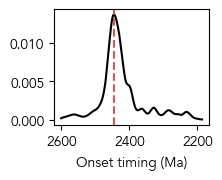

In [4]:
from scipy.stats import gaussian_kde

print(f'66% envelope for onset timing: {np.percentile(onset_list, 17)} - {np.percentile(onset_list, 100-17)}')
print(f'95% envelope for onset timing: {np.percentile(onset_list, 2.5)} - {np.percentile(onset_list, 97.5)}')

# compute maximum likelihood peak age
dy = np.linspace(np.nanmin(onset_list), np.nanmax(onset_list), 10000)

max_like = dy[np.argmax(gaussian_kde(onset_list)(dy))]

print(f'Most likely onset timing: {max_like}')

fig = plt.figure(figsize = (2, 1.5))
plt.plot(dy, gaussian_kde(onset_list)(dy), color = 'k')
plt.axvline(max_like, color = 'indianred', linestyle = 'dashed')
plt.xlabel('Onset timing (Ma)')
plt.gca().invert_xaxis()
plt.show()


66% envelope for peak timing: 2124.0 - 2302.0
95% envelope for peak timing: 2107.0 - 2331.0
Most likely peak timing: 2129.856085608561


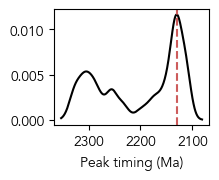

In [5]:
print(f'66% envelope for peak timing: {np.percentile(peak_list, 17)} - {np.percentile(peak_list, 100-17)}')
print(f'95% envelope for peak timing: {np.percentile(peak_list, 2.5)} - {np.percentile(peak_list, 97.5)}')
 
# compute maximum likelihood peak age
dy = np.linspace(np.nanmin(peak_list), np.nanmax(peak_list), 10000)

max_like = dy[np.argmax(gaussian_kde(peak_list)(dy))]

print(f'Most likely peak timing: {max_like}')

fig = plt.figure(figsize = (2, 1.5))
plt.plot(dy, gaussian_kde(peak_list)(dy), color = 'k')
plt.axvline(max_like, color = 'indianred', linestyle = 'dashed')
plt.xlabel('Peak timing (Ma)')
plt.gca().invert_xaxis()
plt.show()

66% envelope for termination timing: 1896.0 - 2028.0
95% envelope for termination timing: 1851.0 - 2049.0
Most likely termination timing: 2018.15301530153


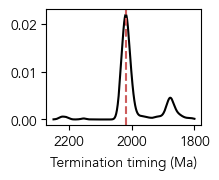

In [6]:
print(f'66% envelope for termination timing: {np.percentile(termination_list, 17)} - {np.percentile(termination_list, 100-17)}')
print(f'95% envelope for termination timing: {np.percentile(termination_list, 2.5)} - {np.percentile(termination_list, 97.5)}')
 
# compute maximum likelihood peak age
dy = np.linspace(np.nanmin(termination_list), np.nanmax(termination_list), 10000)

max_like = dy[np.argmax(gaussian_kde(termination_list)(dy))]

print(f'Most likely termination timing: {max_like}')

fig = plt.figure(figsize = (2, 1.5))
plt.plot(dy, gaussian_kde(termination_list)(dy), color = 'k')
plt.axvline(max_like, color = 'indianred', linestyle = 'dashed')
plt.xlabel('Termination timing (Ma)')
plt.gca().invert_xaxis()
plt.show()

66% envelope for duration: 376.0 - 509.0 Myr
95% envelope for duration: 211.0 - 624.0 Myr
Most likely peak d13C: 428.6987698769877


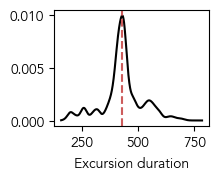

In [7]:
duration_list = np.array(onset_list) - np.array(termination_list)

print(f'66% envelope for duration: {np.percentile(duration_list, 17)} - {np.percentile(duration_list, 100-17)} Myr')
print(f'95% envelope for duration: {np.percentile(duration_list, 2.5)} - {np.percentile(duration_list, 97.5)} Myr')

dy = np.linspace(np.nanmin(duration_list), np.nanmax(duration_list), 10000)

max_like = dy[np.argmax(gaussian_kde(duration_list)(dy))]

print(f'Most likely peak d13C: {max_like}') 

fig = plt.figure(figsize = (2, 1.5))
plt.plot(dy, gaussian_kde(duration_list)(dy), color = 'k')
plt.axvline(max_like, color = 'indianred', linestyle = 'dashed')
plt.xlabel('Excursion duration')
plt.show()

66% envelope for peak d13C: 6.09096256015565 - 8.158348915122389
95% envelope for peak d13C: 4.988649492050679 - 9.457399265002968
Most likely peak d13C: 7.3404330252828185


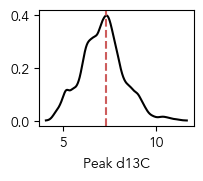

In [8]:
print(f'66% envelope for peak d13C: {np.percentile(peak_d13C_list, 17)} - {np.percentile(peak_d13C_list, 100-17)}')
print(f'95% envelope for peak d13C: {np.percentile(peak_d13C_list, 2.5)} - {np.percentile(peak_d13C_list, 97.5)}')

dy = np.linspace(np.nanmin(peak_d13C_list), np.nanmax(peak_d13C_list), 10000)

max_like = dy[np.argmax(gaussian_kde(peak_d13C_list)(dy))]

print(f'Most likely peak d13C: {max_like}') 

fig = plt.figure(figsize = (2, 1.5))
plt.plot(dy, gaussian_kde(peak_d13C_list)(dy), color = 'k')
plt.axvline(max_like, color = 'indianred', linestyle = 'dashed')
plt.xlabel('Peak d13C')
plt.show()